# Lectures 8: Class demo

### Imports

In [1]:
# import the libraries
import os
import sys
sys.path.append(os.path.join("code"))
from plotting_functions import *
from utils import *

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

%matplotlib inline

pd.set_option("display.max_colwidth", 200)

# c = os.path.join(os.path.abspath(".."), (".."), "data/")
DATA_DIR = os.path.join("data/")
pd.set_option("display.max_colwidth", 200)

In [2]:
from sklearn import set_config

set_config(display="diagram")

<br><br>

Let's look at an example of tuning `max_depth` of the `DecisionTreeClassifier` on the Spotify dataset. 

In [3]:
spotify_df = pd.read_csv(DATA_DIR + "spotify.csv", index_col=0)
X_spotify = spotify_df.drop(columns=["target", "artist"])
y_spotify = spotify_df["target"]
X_spotify.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,song_title
0,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,Mask Off
1,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,Redbone
2,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,Xanny Family
3,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,Master Of None
4,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,Parallel Lines


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X_spotify, y_spotify, test_size=0.2, random_state=123
)

In [5]:
numeric_feats = ['acousticness', 'danceability', 'energy',
                 'instrumentalness', 'liveness', 'loudness',
                 'speechiness', 'tempo', 'valence']
categorical_feats = ['time_signature', 'key']
passthrough_feats = ['mode']
text_feat = "song_title"

In [6]:
from sklearn.compose import make_column_transformer
from sklearn.feature_extraction.text import CountVectorizer

preprocessor = make_column_transformer(
    (StandardScaler(), numeric_feats), 
    (OneHotEncoder(handle_unknown = "ignore"), categorical_feats), 
    ("passthrough", passthrough_feats), 
    (CountVectorizer(max_features=100, stop_words="english"), text_feat)
)

svc_pipe = make_pipeline(preprocessor, SVC)

What's the general approach for model selection? 

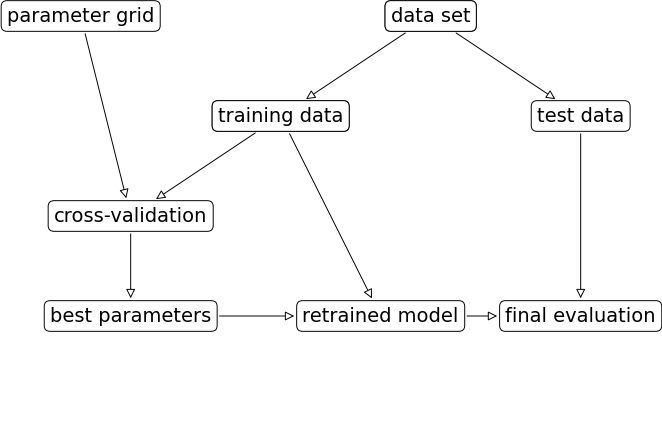

In [7]:
mglearn.plots.plot_grid_search_overview()

Hyperparameter optimization is so common that sklearn includes two classes to automate these steps.

- Exhaustive grid search: [`sklearn.model_selection.GridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
- Randomized search: [`sklearn.model_selection.RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)

The "CV" stands for cross-validation; these methods have built-in cross-validation.

<br><br><br><br>

## Exhaustive grid search: [`sklearn.model_selection.GridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

- For `GridSearchCV` we need
    - an instantiated model or a pipeline
    - a parameter grid: A user specifies a set of values for each hyperparameter. 
    - other optional arguments 

The method considers product of the sets and evaluates each combination one by one.    

In [8]:
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['acousticness', 'danceability', 'energy',
                                  'instrumentalness', 'liveness', 'loudness',
                                  'speechiness', 'tempo', 'valence']),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['time_signature', 'key']),
                                ('passthrough', 'passthrough', ['mode']),
                                ('countvectorizer',
                                 CountVectorizer(max_features=100,
                                                 stop_words='english'),
                                 'song_title')])

In [9]:
from sklearn.model_selection import GridSearchCV

pipe_svm = make_pipeline(preprocessor, SVC())

param_grid = {
    "columntransformer__countvectorizer__max_features": [100, 200, 400, 800, 1000, 2000],
    "svc__gamma": [0.001, 0.01, 0.1, 1.0, 10, 100],
    "svc__C": [0.001, 0.01, 0.1, 1.0, 10, 100],
}

# Create a grid search object 
gs = GridSearchCV(pipe_svm, 
                  param_grid = param_grid, 
                  n_jobs=-1, 
                  return_train_score=True
                 )

The `GridSearchCV` object above behaves like a classifier. We can call `fit`, `predict` or `score` on it. 

In [10]:
# Carry out the search 
gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['acousticness',
                                                                          'danceability',
                                                                          'energy',
                                                                          'instrumentalness',
                                                                          'liveness',
                                                                          'loudness',
                                                                          'speechiness',
                                                                          'tempo',
                                                                          'valence']),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['time_signature',
                                                                          'key']),
                                                                        ('passthrough',
                                                                         'passthrough',
                                                                         ['mode']),
                                                                        ('countvectorizer',
                                                                         CountVectorizer(max_features=100,
                                                                                         stop_words='english'),
                                                                         'song_title')])),
                                       ('svc', SVC())]),
             n_jobs=-1,
             param_grid={'columntransformer__countvectorizer__max_features': [100,
                                                                              200,
                                                                              400,
                                                                              800,
                                                                              1000,
                                                                              2000],
                         'svc__C': [0.001, 0.01, 0.1, 1.0, 10, 100],
                         'svc__gamma': [0.001, 0.01, 0.1, 1.0, 10, 100]},
             return_train_score=True)

Fitting the `GridSearchCV` object 
- Searches for the best hyperparameter values
- You can access the best score and the best hyperparameters using `best_score_` and `best_params_` attributes, respectively. 

In [11]:
# Get the best score
gs.best_score_

np.float64(0.7395977155164125)

In [12]:
# Get the best hyperparameter values
gs.best_params_

{'columntransformer__countvectorizer__max_features': 1000,
 'svc__C': 1.0,
 'svc__gamma': 0.1}

- It is often helpful to visualize results of all cross-validation experiments. 
- You can access this information using `cv_results_` attribute of a fitted `GridSearchCV` object.  

In [13]:
results = pd.DataFrame(gs.cv_results_)
results.T

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
mean_fit_time,0.072795,0.077747,0.064875,0.061541,0.059356,0.060548,0.06252,0.073111,0.066146,0.104828,...,0.099394,0.092672,0.098724,0.089343,0.076685,0.124902,0.097298,0.091613,0.09137,0.085101
std_fit_time,0.012479,0.006163,0.010712,0.002968,0.009631,0.002394,0.008096,0.007309,0.019038,0.0128,...,0.006738,0.012346,0.011212,0.01134,0.004751,0.016369,0.007533,0.006265,0.009019,0.009476
mean_score_time,0.017065,0.016142,0.019221,0.014762,0.01956,0.014745,0.016839,0.014905,0.015685,0.025758,...,0.017311,0.018079,0.017906,0.017051,0.015355,0.020849,0.016929,0.019559,0.020633,0.016945
std_score_time,0.003109,0.00224,0.005703,0.002086,0.006566,0.002413,0.003311,0.001951,0.003551,0.005513,...,0.002647,0.00297,0.002938,0.00288,0.002732,0.009965,0.004128,0.00418,0.003351,0.002505
param_columntransformer__countvectorizer__max_features,100,100,100,100,100,100,100,100,100,100,...,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000
param_svc__C,0.001,0.001,0.001,0.001,0.001,0.001,0.01,0.01,0.01,0.01,...,10.0,10.0,10.0,10.0,100.0,100.0,100.0,100.0,100.0,100.0
param_svc__gamma,0.001,0.01,0.1,1.0,10.0,100.0,0.001,0.01,0.1,1.0,...,0.1,1.0,10.0,100.0,0.001,0.01,0.1,1.0,10.0,100.0
params,"{'columntransformer__countvectorizer__max_features': 100, 'svc__C': 0.001, 'svc__gamma': 0.001}","{'columntransformer__countvectorizer__max_features': 100, 'svc__C': 0.001, 'svc__gamma': 0.01}","{'columntransformer__countvectorizer__max_features': 100, 'svc__C': 0.001, 'svc__gamma': 0.1}","{'columntransformer__countvectorizer__max_features': 100, 'svc__C': 0.001, 'svc__gamma': 1.0}","{'columntransformer__countvectorizer__max_features': 100, 'svc__C': 0.001, 'svc__gamma': 10}","{'columntransformer__countvectorizer__max_features': 100, 'svc__C': 0.001, 'svc__gamma': 100}","{'columntransformer__countvectorizer__max_features': 100, 'svc__C': 0.01, 'svc__gamma': 0.001}","{'columntransformer__countvectorizer__max_features': 100, 'svc__C': 0.01, 'svc__gamma': 0.01}","{'columntransformer__countvectorizer__max_features': 100, 'svc__C': 0.01, 'svc__gamma': 0.1}","{'columntransformer__countvectorizer__max_features': 100, 'svc__C': 0.01, 'svc__gamma': 1.0}",...,"{'columntransformer__countvectorizer__max_features': 2000, 'svc__C': 10, 'svc__gamma': 0.1}","{'columntransformer__countvectorizer__max_features': 2000, 'svc__C': 10, 'svc__gamma': 1.0}","{'columntransformer__countvectorizer__max_features': 2000, 'svc__C': 10, 'svc__gamma': 10}","{'columntransformer__countvectorizer__max_features': 2000, 'svc__C': 10, 'svc__gamma': 100}","{'columntransformer__countvectorizer__max_features': 2000, 'svc__C': 100, 'svc__gamma': 0.001}","{'columntransformer__countvectorizer__max_features': 2000, 'svc__C': 100, 'svc__gamma': 0.01}","{'columntransformer__countvectorizer__max_features': 2000, 'svc__C': 100, 'svc__gamma': 0.1}","{'columntransformer__countvectorizer__max_features': 2000, 'svc__C': 100, 'svc__gamma': 1.0}","{'columntransformer__countvectorizer__max_features': 2000, 'svc__C': 100, 'svc__gamma': 10}","{'columntransformer__countvectorizer__max_features': 2000, 'svc__C': 100, 'svc__gamma': 100}"
split0_test_score,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,...,0.733746,0.616099,0.50774,0.504644,0.718266,0.718266,0.724458,0.616099,0.50774,0.504644
split1_test_score,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,...,0.77709,0.625387,0.510836,0.510836,0.724458,0.739938,0.764706,0.625387,0.510836,0.510836


In [14]:
results = (
    pd.DataFrame(gs.cv_results_).set_index("rank_test_score").sort_index()
)
display(results.T)

rank_test_score,1,2,3,4,5,5,7,8,9,10,...,121,121,121,121,121,121,121,121,121,121
mean_fit_time,0.077641,0.0739,0.05649,0.067793,0.083328,0.057365,0.102444,0.088645,0.099394,0.083791,...,0.088646,0.071618,0.071065,0.073696,0.089042,0.076124,0.090765,0.072843,0.118139,0.072795
std_fit_time,0.00351,0.010495,0.002523,0.007569,0.041069,0.008576,0.009202,0.007258,0.006738,0.00859,...,0.010101,0.00453,0.003122,0.01155,0.005749,0.009169,0.022888,0.012742,0.036793,0.012479
mean_score_time,0.017095,0.014022,0.013326,0.019091,0.027363,0.015515,0.01651,0.017573,0.017311,0.016206,...,0.021499,0.022962,0.019523,0.021458,0.01955,0.0196,0.021151,0.016569,0.018719,0.017065
std_score_time,0.003617,0.000614,0.001663,0.004571,0.017917,0.005022,0.001573,0.003807,0.002647,0.002815,...,0.003604,0.006253,0.004513,0.005289,0.002982,0.006353,0.011168,0.004594,0.003241,0.003109
param_columntransformer__countvectorizer__max_features,1000,2000,400,800,200,100,800,1000,2000,400,...,1000,1000,1000,400,400,400,400,400,1000,100
param_svc__C,1.0,1.0,1.0,1.0,1.0,1.0,10.0,10.0,10.0,10.0,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
param_svc__gamma,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,0.1,0.01,0.001,0.001,0.01,0.1,1.0,10.0,100.0,0.001
params,"{'columntransformer__countvectorizer__max_features': 1000, 'svc__C': 1.0, 'svc__gamma': 0.1}","{'columntransformer__countvectorizer__max_features': 2000, 'svc__C': 1.0, 'svc__gamma': 0.1}","{'columntransformer__countvectorizer__max_features': 400, 'svc__C': 1.0, 'svc__gamma': 0.1}","{'columntransformer__countvectorizer__max_features': 800, 'svc__C': 1.0, 'svc__gamma': 0.1}","{'columntransformer__countvectorizer__max_features': 200, 'svc__C': 1.0, 'svc__gamma': 0.1}","{'columntransformer__countvectorizer__max_features': 100, 'svc__C': 1.0, 'svc__gamma': 0.1}","{'columntransformer__countvectorizer__max_features': 800, 'svc__C': 10, 'svc__gamma': 0.1}","{'columntransformer__countvectorizer__max_features': 1000, 'svc__C': 10, 'svc__gamma': 0.1}","{'columntransformer__countvectorizer__max_features': 2000, 'svc__C': 10, 'svc__gamma': 0.1}","{'columntransformer__countvectorizer__max_features': 400, 'svc__C': 10, 'svc__gamma': 0.1}",...,"{'columntransformer__countvectorizer__max_features': 1000, 'svc__C': 0.001, 'svc__gamma': 0.1}","{'columntransformer__countvectorizer__max_features': 1000, 'svc__C': 0.001, 'svc__gamma': 0.01}","{'columntransformer__countvectorizer__max_features': 1000, 'svc__C': 0.001, 'svc__gamma': 0.001}","{'columntransformer__countvectorizer__max_features': 400, 'svc__C': 0.001, 'svc__gamma': 0.001}","{'columntransformer__countvectorizer__max_features': 400, 'svc__C': 0.001, 'svc__gamma': 0.01}","{'columntransformer__countvectorizer__max_features': 400, 'svc__C': 0.001, 'svc__gamma': 0.1}","{'columntransformer__countvectorizer__max_features': 400, 'svc__C': 0.001, 'svc__gamma': 1.0}","{'columntransformer__countvectorizer__max_features': 400, 'svc__C': 0.001, 'svc__gamma': 10}","{'columntransformer__countvectorizer__max_features': 1000, 'svc__C': 0.001, 'svc__gamma': 100}","{'columntransformer__countvectorizer__max_features': 100, 'svc__C': 0.001, 'svc__gamma': 0.001}"
split0_test_score,0.764706,0.767802,0.764706,0.76161,0.758514,0.76161,0.727554,0.718266,0.733746,0.739938,...,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774
split1_test_score,0.767802,0.770898,0.764706,0.76161,0.758514,0.755418,0.77709,0.783282,0.77709,0.783282,...,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774


Let's only look at the most relevant rows. 

In [15]:
pd.DataFrame(gs.cv_results_)[
    [
        "mean_test_score",
        "param_columntransformer__countvectorizer__max_features", 
        "param_svc__gamma",
        "param_svc__C",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index().T

rank_test_score,1,2,3,4,5,5,7,8,9,10,...,121,121,121,121,121,121,121,121,121,121
mean_test_score,0.739598,0.738977,0.736498,0.735879,0.735261,0.735261,0.727829,0.727198,0.726583,0.726573,...,0.507750,0.507750,0.507750,0.507750,0.507750,0.507750,0.507750,0.507750,0.507750,0.507750
param_columntransformer__countvectorizer__max_features,1000.000000,2000.000000,400.000000,800.000000,200.000000,100.000000,800.000000,1000.000000,2000.000000,400.000000,...,1000.000000,1000.000000,1000.000000,400.000000,400.000000,400.000000,400.000000,400.000000,1000.000000,100.000000
param_svc__gamma,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,...,0.100000,0.010000,0.001000,0.001000,0.010000,0.100000,1.000000,10.000000,100.000000,0.001000
param_svc__C,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000,10.000000,10.000000,10.000000,...,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000
mean_fit_time,0.077641,0.073900,0.056490,0.067793,0.083328,0.057365,0.102444,0.088645,0.099394,0.083791,...,0.088646,0.071618,0.071065,0.073696,0.089042,0.076124,0.090765,0.072843,0.118139,0.072795


- Other than searching for best hyperparameter values, `GridSearchCV` also fits a new model on the whole training set with the parameters that yielded the best results. 
- So we can conveniently call `score` on the test set with a fitted `GridSearchCV` object. 

In [16]:
# Get the test scores 

gs.score(X_test, y_test)

0.7574257425742574

Why are `best_score_` and the score above different? 

### `n_jobs=-1`
- Note the `n_jobs=-1` above.
- Hyperparameter optimization can be done _in parallel_ for each of the configurations.
- This is very useful when scaling up to large numbers of machines in the cloud.
- When you set `n_jobs=-1`, it means that you want to use all available CPU cores for the task. 

### The `__` syntax 

- Above: we have a nesting of transformers.
- We can access the parameters of the "inner" objects by using __ to go "deeper":
- `svc__gamma`: the `gamma` of the `svc` of the pipeline
- `svc__C`: the `C` of the `svc` of the pipeline
- `columntransformer__countvectorizer__max_features`: the `max_features` hyperparameter of `CountVectorizer` in the column transformer `preprocessor`. 

In [17]:
pipe_svm

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['acousticness',
                                                   'danceability', 'energy',
                                                   'instrumentalness',
                                                   'liveness', 'loudness',
                                                   'speechiness', 'tempo',
                                                   'valence']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['time_signature', 'key']),
                                                 ('passthrough', 'passthrough',
                                                  ['mode']),
                                                 ('countvectorizer',
                                                  CountVectorizer(max_features=100,
                                                                  stop_words='english'),
                                                  'song_title')])),
                ('svc', SVC())])

### Range of `C`

- Note the exponential range for `C`. This is quite common. Using this exponential range allows you to explore a wide range of values efficiently.
- There is no point trying $C=\{1,2,3\ldots,100\}$ because $C=1,2,3$ are too similar to each other.
- Often we're trying to find an order of magnitude, e.g. $C=\{0.01,0.1,1,10,100\}$. 
- We can also write that as $C=\{10^{-2},10^{-1},10^0,10^1,10^2\}$. 
- Or, in other words, $C$ values to try are $10^n$ for $n=-2,-1,0,1,2$ which is basically what we have above.

<br><br>

### Visualizing the parameter grid as a heatmap 

In [18]:
def display_heatmap(param_grid, pipe, X_train, y_train):
    grid_search = GridSearchCV(
        pipe, param_grid, cv=5, n_jobs=-1, return_train_score=True
    )
    grid_search.fit(X_train, y_train)
    results = pd.DataFrame(grid_search.cv_results_)
    scores = np.array(results.mean_test_score).reshape(6, 6)

    # plot the mean cross-validation scores
    my_heatmap(
        scores,
        xlabel="gamma",
        xticklabels=param_grid["svc__gamma"],
        ylabel="C",
        yticklabels=param_grid["svc__C"],
        cmap="viridis",
    );

- Note that the range we pick for the parameters play an important role in hyperparameter optimization. 
- For example, consider the following grid and the corresponding results.  

In [ ]:
param_grid1 = {
    "svc__gamma": 10.0**np.arange(-3, 3, 1), 
    "svc__C": 10.0**np.arange(-3, 3, 1)
}
display_heatmap(param_grid1, pipe_svm, X_train, y_train)

- Each point in the heat map corresponds to one run of cross-validation, with a particular setting
- Colour encodes cross-validation accuracy. 
    - Lighter colour means high accuracy
    - Darker colour means low accuracy
- SVC is quite sensitive to hyperparameter settings.
- Adjusting hyperparameters can change the accuracy from 0.51 to 0.74! 

### Bad range for hyperparameters 

In [ ]:
np.logspace(1, 2, 6)

array([ 10.        ,  15.84893192,  25.11886432,  39.81071706,
        63.09573445, 100.        ])

In [ ]:
np.linspace(1, 2, 6)

array([1. , 1.2, 1.4, 1.6, 1.8, 2. ])

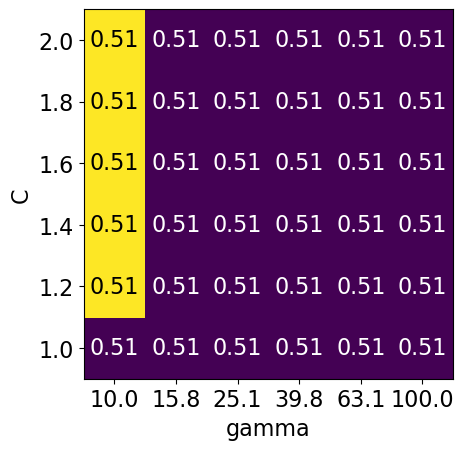

In [ ]:
param_grid2 = {"svc__gamma": np.round(np.logspace(1, 2, 6), 1), "svc__C": np.linspace(1, 2, 6)}
display_heatmap(param_grid2, pipe_svm, X_train, y_train)

### Different range for hyperparameters yields better results! 

In [ ]:
np.logspace(-3, 2, 6)

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])

In [ ]:
np.linspace(1, 2, 6)

array([1. , 1.2, 1.4, 1.6, 1.8, 2. ])

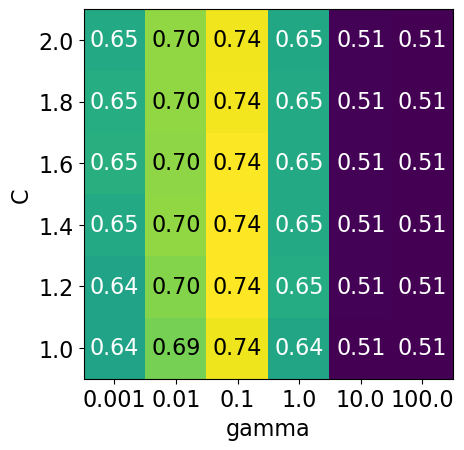

In [ ]:
param_grid3 = {"svc__gamma": np.logspace(-3, 2, 6), "svc__C": np.linspace(1, 2, 6)}

display_heatmap(param_grid3, pipe_svm, X_train, y_train)

It seems like we are getting even better cross-validation results with `C` = 2.0 and `gamma` = 0.1 

How about exploring different values of `C` close to 2.0? 

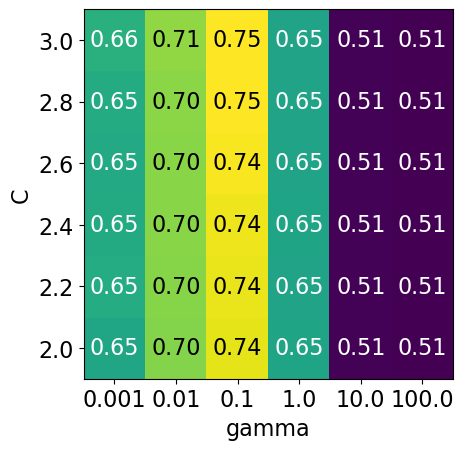

In [ ]:
param_grid4 = {"svc__gamma": np.logspace(-3, 2, 6), "svc__C": np.linspace(2, 3, 6)}

display_heatmap(param_grid4, pipe_svm, X_train, y_train)

That's good! We are finding some more options for `C` where the accuracy is 0.75. 
The tricky part is we do not know in advance what range of hyperparameters might work the best for the given problem, model, and the dataset.    

```{note}
`GridSearchCV` allows the param_grid to be a list of dictionaries. Sometimes some hyperparameters are applicable only for certain models. 
For example, in the context of `SVC`, `C` and `gamma` are applicable when the kernel is `rbf` whereas only `C` is applicable for `kernel="linear"`.    
```

### Problems with exhaustive grid search 

- Required number of models to evaluate grows exponentially with the dimensionally of the configuration space. 
- Example: Suppose you have
    - 5 hyperparameters 
    - 10 different values for each hyperparameter
    - You'll be evaluating $10^5=100,000$ models! That is you'll be calling `cross_validate` 100,000 times!
- Exhaustive search may become infeasible fairly quickly. 
- Other options? 

<br><br><br><br>

## Randomized hyperparameter search

- Randomized hyperparameter optimization 
    - [`sklearn.model_selection.RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
- Samples configurations at random until certain budget (e.g., time) is exhausted 

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    "columntransformer__countvectorizer__max_features": [100, 200, 400, 800, 1000, 2000],
    "svc__gamma": [0.001, 0.01, 0.1, 1.0, 10, 100],
    "svc__C": np.linspace(2, 3, 6),
}

print("Grid size: %d" % (np.prod(list(map(len, param_grid.values())))))
param_grid

Grid size: 216


{'columntransformer__countvectorizer__max_features': [100,
  200,
  400,
  800,
  1000,
  2000],
 'svc__gamma': [0.001, 0.01, 0.1, 1.0, 10, 100],
 'svc__C': array([2. , 2.2, 2.4, 2.6, 2.8, 3. ])}

In [ ]:
# Create a random search object
random_search = RandomizedSearchCV(pipe_svm,                                    
                  param_distributions = param_grid, 
                  n_iter=100, 
                  n_jobs=-1, 
                  return_train_score=True)

# Carry out the search
random_search.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['acousticness',
                                                                                'danceability',
                                                                                'energy',
                                                                                'instrumentalness',
                                                                                'liveness',
                                                                                'loudness',
                                                                                'speechiness',
                                                                                'tempo',
                                                                                'valence']),
                                                                              ('onehotencoder',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['time_signature',
                                                                                'key']),
                                                                              ('passthrough',
                                                                               'passthrough',
                                                                               ['mode']),
                                                                              ('countvectorizer',
                                                                               CountVectorizer(max_features=100,
                                                                                               stop_words='english'),
                                                                               'song_title')])),
                                             ('svc', SVC())]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'columntransformer__countvectorizer__max_features': [100,
                                                                                             200,
                                                                                             400,
                                                                                             800,
                                                                                             1000,
                                                                                             2000],
                                        'svc__C': array([2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
                                        'svc__gamma': [0.001, 0.01, 0.1, 1.0,
                                                       10, 100]},
                   return_train_score=True)

In [ ]:
pd.DataFrame(random_search.cv_results_)[
    [
        "mean_test_score",
        "param_columntransformer__countvectorizer__max_features", 
        "param_svc__gamma",
        "param_svc__C",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index().T

rank_test_score,1,2,3,3,5,5,7,7,9,10,...,81,81,81,81,81,81,81,81,81,81
mean_test_score,0.745801,0.743324,0.743323,0.743323,0.741465,0.741465,0.741463,0.741463,0.740842,0.739605,...,0.508371,0.508371,0.508371,0.508371,0.508371,0.508371,0.508371,0.508371,0.508371,0.508371
param_columntransformer__countvectorizer__max_features,100.000000,2000.000000,200.000000,100.000000,400.000000,800.000000,1000.000000,1000.000000,200.000000,2000.000000,...,100.000000,1000.000000,100.000000,800.000000,200.000000,200.000000,2000.000000,2000.000000,1000.000000,1000.000000
param_svc__gamma,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
param_svc__C,2.800000,2.200000,2.600000,2.600000,2.400000,2.400000,2.600000,3.000000,3.000000,3.000000,...,2.800000,2.800000,2.200000,2.200000,2.000000,2.800000,2.200000,2.800000,2.000000,2.400000
mean_fit_time,0.061791,0.101440,0.065473,0.061137,0.071853,0.092636,0.104751,0.087756,0.072307,0.109054,...,0.076591,0.093536,0.075431,0.095205,0.079976,0.079630,0.098189,0.102068,0.089423,0.092968


### `n_iter`

- Note the `n_iter`, we didn't need this for `GridSearchCV`.
- Larger `n_iter` will take longer but it'll do more searching.
  - Remember you still need to multiply by number of folds!
- I have set the `random_state` for reproducibility but you don't have to do it.

### (Optional) Passing probability distributions to random search

Another thing we can do is give probability distributions to draw from:

In [ ]:
from scipy.stats import expon, lognorm, loguniform, randint, uniform, norm, randint

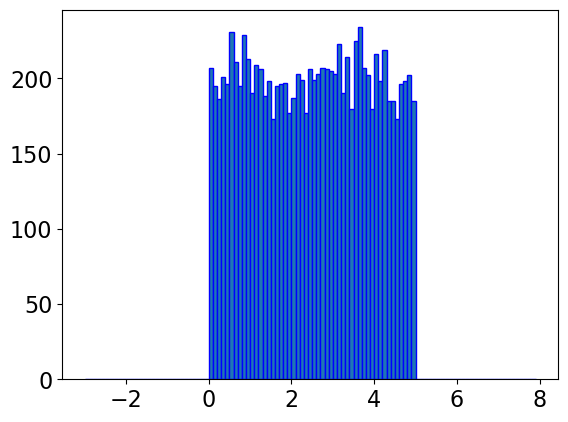

In [ ]:
np.random.seed(123)

y = uniform.rvs(0, 5, 10000)
bin = np.arange(-3,8,0.1)  

plt.hist(y, bins=bin, edgecolor='blue') 
plt.show()

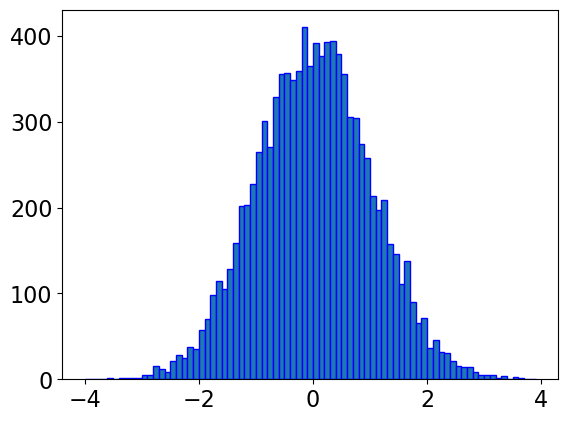

In [ ]:
y = norm.rvs(0, 1, 10000)

#creating bin
bin = np.arange(-4,4,0.1)  

plt.hist(y, bins=bin, edgecolor='blue') 
plt.show()

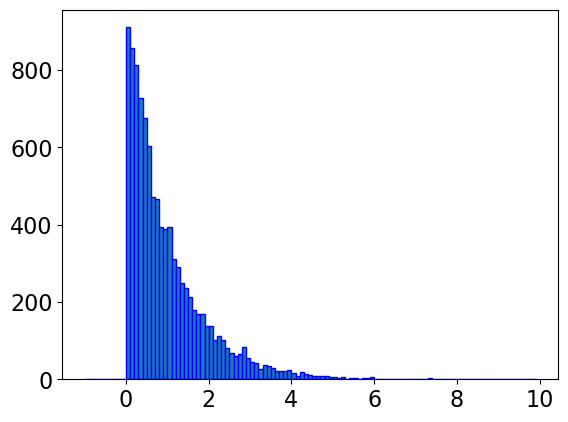

In [ ]:
y = expon.rvs(0, 1, 10000)

#creating bin
bin = np.arange(-1,10,0.1)  

plt.hist(y, bins=bin, edgecolor='blue') 
plt.show()

<br><br>

In [ ]:
pipe_svm

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['acousticness',
                                                   'danceability', 'energy',
                                                   'instrumentalness',
                                                   'liveness', 'loudness',
                                                   'speechiness', 'tempo',
                                                   'valence']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['time_signature', 'key']),
                                                 ('passthrough', 'passthrough',
                                                  ['mode']),
                                                 ('countvectorizer',
                                                  CountVectorizer(max_features=100,
                                                                  stop_words='english'),
                                                  'song_title')])),
                ('svc', SVC())])

In [ ]:
from scipy.stats import randint

param_dist = {
    "columntransformer__countvectorizer__max_features": randint(100, 2000), 
    "svc__C": uniform(0.1, 1e4),  # loguniform(1e-3, 1e3),
    "svc__gamma": loguniform(1e-5, 1e3),
}

In [ ]:
# Create a random search object
random_search = RandomizedSearchCV(pipe_svm,                                    
                  param_distributions = param_dist, 
                  n_iter=100, 
                  n_jobs=-1, 
                  return_train_score=True)

# Carry out the search
random_search.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['acousticness',
                                                                                'danceability',
                                                                                'energy',
                                                                                'instrumentalness',
                                                                                'liveness',
                                                                                'loudness',
                                                                                'speechiness',
                                                                                'tempo',
                                                                                'valence']),
                                                                              ('onehotencoder',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['time_signature',
                                                                                'key']),
                                                                              ('passthrough',
                                                                               'pass...
                   n_iter=100, n_jobs=-1,
                   param_distributions={'columntransformer__countvectorizer__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x15e26a3c0>,
                                        'svc__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x15d708860>,
                                        'svc__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x15e4b8e30>},
                   return_train_score=True)

In [ ]:
random_search.best_score_

0.7278214718381631

In [ ]:
pd.DataFrame(random_search.cv_results_)[
    [
        "mean_test_score",
        "param_columntransformer__countvectorizer__max_features",
        "param_svc__gamma",
        "param_svc__C",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index().T

rank_test_score,1,2,3,4,5,6,7,8,9,10,...,76,76,76,94,94,94,94,94,94,94
mean_test_score,0.727821,0.722241,0.721616,0.721006,0.715424,0.712324,0.711717,0.711086,0.709880,0.709874,...,0.508371,0.508371,0.508371,0.507130,0.507130,0.507130,0.507130,0.507130,0.507130,0.507130
param_columntransformer__countvectorizer__max_features,1619.000000,1014.000000,688.000000,1880.000000,224.000000,947.000000,987.000000,386.000000,1997.000000,1963.000000,...,928.000000,1953.000000,445.000000,1397.000000,776.000000,1715.000000,1562.000000,1854.000000,708.000000,1631.000000
param_svc__gamma,0.123539,0.165811,0.336735,0.101688,0.000976,0.126563,0.000508,0.000917,0.032324,0.000503,...,18.053918,226.698857,40.024122,387.490568,268.760262,845.206099,358.257024,601.401895,984.435792,461.301200
param_svc__C,7551.390429,477.418069,8502.828976,2806.696859,9471.173025,9295.688135,559.066944,3590.674490,7951.972198,1520.347523,...,7758.841886,9203.835651,3089.543297,2144.534114,7736.150115,2451.353961,1813.530052,1564.825306,2192.718242,389.888811
mean_fit_time,0.104799,0.103038,0.099242,0.113293,0.373315,0.105528,0.089173,0.172094,0.126151,0.128544,...,0.101496,0.105458,0.091038,0.092165,0.081682,0.095494,0.099140,0.092068,0.085304,0.094345


- This is a bit fancy. What's nice is that you can have it concentrate more on certain values by setting the distribution. 


### Advantages of `RandomizedSearchCV`

- Faster compared to `GridSearchCV`.
- Adding parameters that do not influence the performance does not affect efficiency.
- Works better when some parameters are more important than others. 
- In general, I recommend using `RandomizedSearchCV` rather than `GridSearchCV`.    

### Advantages of `RandomizedSearchCV`

![](../../img/randomsearch_bergstra.png)
    
Source: [Bergstra and Bengio, Random Search for Hyper-Parameter Optimization, JMLR 2012](http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf).

- The yellow on the left shows how your scores are going to change when you vary the unimportant hyperparameter.
- The green on the top shows how your scores are  going to change when you vary the important hyperparameter.
- You don't know in advance which hyperparameters are important for your problem.
- In the left figure, 6 of the 9 searches are useless because they are only varying the unimportant parameter.
- In the right figure, all 9 searches are useful.

### (Optional) Searching for optimal parameters with successive halving¶

- Successive halving is an iterative selection process where all candidates (the parameter combinations) are evaluated with a small amount of resources (e.g., small amount of training data) at the first iteration.
- Checkout [successive halving with grid search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingGridSearchCV.html) and [random search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingRandomSearchCV.html).

In [ ]:
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV

In [ ]:
rsh = HalvingRandomSearchCV(
    estimator=pipe_svm, param_distributions=param_dist, factor=2, random_state=123
)
rsh.fit(X_train, y_train)

In [ ]:
results = pd.DataFrame(rsh.cv_results_)
results["params_str"] = results.params.apply(str)
results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
results

## (Optional) Fancier methods 
- Both `GridSearchCV` and `RandomizedSearchCV` do each trial independently.
- What if you could learn from your experience, e.g. learn that `max_depth=3` is bad?
  - That could save time because you wouldn't try combinations involving `max_depth=3` in the future.
- We can do this with `scikit-optimize`, which is a completely different package from `scikit-learn`
- It uses a technique called "model-based optimization" and we'll specifically use "Bayesian optimization".
  - In short, it uses machine learning to predict what hyperparameters will be good.
  - Machine learning on machine learning!

- This is an active research area and there are sophisticated packages for this.

Here are some examples 
- [hyperopt-sklearn](https://github.com/hyperopt/hyperopt-sklearn)
- [auto-sklearn](https://github.com/automl/auto-sklearn)
- [SigOptSearchCV](https://sigopt.com/docs/overview/scikit_learn)
- [TPOT](https://github.com/rhiever/tpot)
- [hyperopt](https://github.com/hyperopt/hyperopt)
- [hyperband](https://github.com/zygmuntz/hyperband)
- [SMAC](http://www.cs.ubc.ca/labs/beta/Projects/SMAC/)
- [MOE](https://github.com/Yelp/MOE)
- [pybo](https://github.com/mwhoffman/pybo)
- [spearmint](https://github.com/HIPS/Spearmint)
- [BayesOpt](https://github.com/rmcantin/bayesopt)